In [1]:
import os
import json
import time
import copy

import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as f
from monai.networks.nets import UNETR, UNet
from monai.losses import DiceLoss

In [2]:
data_dir = r'../../Shared_Datasets/burns/segmentation/Dataset_Augmented/'
labels_dir = r'../../Shared_Datasets/burns/segmentation/Masks_Greyscale_Augmented/'
save_dir = r'./'

#data_dir = r'../data/segmentation/Dataset_Augmented'
#labels_dir = r'../data/segmentation/Masks_Greyscale_Augmented'

In [3]:
mode = "train"
model_type = "unetr"   #unetr, unet1, unet2
batch_size = 8
device = torch.device("cuda:0")
learning_rate = 0.00005
n_epochs = 30
#n_epochs = 60
n_channels = 3

In [4]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def to_colorrep(x):
    mask = torch.zeros(1, 256, 256)
    mask[0][x[0] == 1] = 127
    mask[0][x[1] == 1] = 255
    return mask

def iou(x1, x2):
    xc = x1 + x2
    inter = (xc / 2).round().sum()
    unio = xc.ceil(1).sum()
    return inter / unio
    

In [5]:
class BurnRGBDataset(Dataset):
    def __init__(self, inputs_dir, masks_dir):
        self.inputs_dir = inputs_dir
        self.masks_dir = masks_dir
        self.data = os.listdir(self.inputs_dir)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        file_name = self.data[index].split(".")[0]
        input_file = os.path.join(self.inputs_dir, file_name + ".png")
        mask_file = os.path.join(self.masks_dir, file_name + ".png")
        image = Image.open(input_file)
        mask = Image.open(mask_file)
        image = np.array(image)
        image = image.transpose(2, 0, 1) / 255
        mask = np.array(mask)
        target = torch.zeros(2, 256, 256)
        target[0][mask == 0] = 0
        target[1][mask == 0] = 0
        target[0][mask == 127] = 1
        target[1][mask == 255] = 1
        img = torch.from_numpy(image).type(torch.FloatTensor)
        return (img, target)

In [6]:
def train_model(model, device, epochs, batch_size, lr, n_train, n_val, dataloader):
    start = time.time()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    #criterion = nn.CrossEntropyLoss()
    criterion = DiceLoss(to_onehot_y=True, softmax=True)
    model = model.to(device)
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        for phase in ['Train', 'Val']:
            running_loss = 0.0
            running_corrects = 0.0
            if phase == 'Train':
                model.train()
                for images, targets in tqdm(dataloader[phase]):
                    images = images.to(device, dtype=torch.float32)
                    targets = targets.to(device, dtype=torch.long)
                    optimizer.zero_grad()
                    outputs = model(images)
                    _, predictions = torch.max(outputs, 1)
                    _, target_classes = torch.max(targets, 1)
                    loss = criterion(outputs[:,0:1,:,:], targets[:,0:1,:,:])
                    loss += criterion(outputs[:,1:,:,:], targets[:,1:,:,:])
                    loss = loss / 2
                    loss.backward()
                    nn.utils.clip_grad_value_(model.parameters(), 0.1)
                    optimizer.step()
                    running_loss += loss.item() * images.size(0)
                    running_corrects += torch.sum(predictions == target_classes) / (256 ** 2)
            else:
                model.eval()
                for images, targets in tqdm(dataloader[phase]):
                    images = images.to(device, dtype=torch.float32)
                    targets = targets.to(device, dtype=torch.long)
                    optimizer.zero_grad()
                    with torch.no_grad():
                        outputs = model(images)
                        _, predictions = torch.max(outputs, 1)
                        _, target_classes = torch.max(targets, 1)
                        loss = criterion(outputs[:,0:1,:,:], targets[:,0:1,:,:])
                        loss += criterion(outputs[:,1:,:,:], targets[:,1:,:,:])
                        loss = loss / 2
                    running_loss += loss.item() * images.size(0)
                    running_corrects += torch.sum(predictions == target_classes) / (256 ** 2)
                scheduler.step()
            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = (running_corrects / len(dataloader[phase].dataset)).cpu().numpy()
            print('{} Loss: {:.4f}  Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'Train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_weights = copy.deepcopy(model.state_dict())
    train_time = time.time() - start
    print('Training complete in {:.0f}m {:.0f}'.format(train_time // 60, train_time % 60))
    print('Best validation accuracy: {:.4f}'.format(best_acc))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(epochs)), train_loss, color='skyblue', label='Train')
    plt.plot(list(range(epochs)), valid_loss, color='orange', label='Val')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(list(range(epochs)), train_acc, color='skyblue', label='Train')
    plt.plot(list(range(epochs)), valid_acc, color='orange', label='Val')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.savefig(os.path.join(save_dir, "training_plots.png"))
    model.load_state_dict(best_model_weights)
    return (model, train_loss, train_acc, valid_loss, valid_acc)

In [7]:
# Create training and validation datasets
train_ds = BurnRGBDataset(os.path.join(data_dir, "Train"), os.path.join(labels_dir, "Train"))
valid_ds = BurnRGBDataset(os.path.join(data_dir, "Val"), os.path.join(labels_dir, "Val"))

# Create training and validation dataloaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last = True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, drop_last = False)
dataloader = {'Train': train_dl, 'Val': valid_dl}

In [8]:
if model_type == "unetr":
    model = UNETR(
        in_channels=3,
        out_channels=2,
        img_size=(256, 256),
        spatial_dims=2,
        feature_size=16,
        hidden_size=768,
        mlp_dim=3072,
        num_heads=12,
        pos_embed="perceptron",
        norm_name="instance",
        res_block=True,
        dropout_rate=0.0,
    )
    model = nn.Sequential(model, nn.Sigmoid()).to(device)
elif model_type == "unet1":
    model = UNet(
        spatial_dims=2,
        in_channels=3,
        out_channels=2,
        channels=(4, 8, 16),
        strides=(2, 2),
        num_res_units=2
    )
    model = nn.Sequential(model, nn.Sigmoid()).to(device)
elif model_type == "unet2":
    model = UNet(
        spatial_dims=2,
        in_channels=3,
        out_channels=2,
        channels=(4, 8, 16, 32, 64),
        strides=(2, 2, 2, 2),
    )
    model = nn.Sequential(model, nn.Sigmoid()).to(device)



In [9]:
model

Sequential(
  (0): UNETR(
    (vit): ViT(
      (patch_embedding): PatchEmbeddingBlock(
        (patch_embeddings): Sequential(
          (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
          (1): Linear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (blocks): ModuleList(
        (0): TransformerBlock(
          (mlp): MLPBlock(
            (linear1): Linear(in_features=768, out_features=3072, bias=True)
            (linear2): Linear(in_features=3072, out_features=768, bias=True)
            (fn): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): SABlock(
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
            (qkv): Linear(in_features=768, out_features=2304, bias=False)
            (input_rearran

Epoch 1/30


  0%|                                                                                          | 0/101 [00:00<?, ?it/s]single channel prediction, `softmax=True` ignored.
single channel prediction, `to_onehot_y=True` ignored.
100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:45<00:00,  2.21it/s]


Train Loss: 0.6122  Acc: 0.5895


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.91it/s]


Val Loss: 0.5478  Acc: 0.6295
Epoch 2/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:43<00:00,  2.32it/s]


Train Loss: 0.5071  Acc: 0.6544


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


Val Loss: 0.4887  Acc: 0.6770
Epoch 3/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:44<00:00,  2.25it/s]


Train Loss: 0.4659  Acc: 0.7062


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.73it/s]


Val Loss: 0.4587  Acc: 0.7223
Epoch 4/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:44<00:00,  2.25it/s]


Train Loss: 0.4425  Acc: 0.7458


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.46it/s]


Val Loss: 0.4393  Acc: 0.7621
Epoch 5/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:45<00:00,  2.23it/s]


Train Loss: 0.4234  Acc: 0.7784


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


Val Loss: 0.4263  Acc: 0.7917
Epoch 6/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:44<00:00,  2.29it/s]


Train Loss: 0.4084  Acc: 0.8083


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Val Loss: 0.4150  Acc: 0.8119
Epoch 7/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:43<00:00,  2.31it/s]


Train Loss: 0.3963  Acc: 0.8228


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.62it/s]


Val Loss: 0.4052  Acc: 0.8265
Epoch 8/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:44<00:00,  2.27it/s]


Train Loss: 0.3865  Acc: 0.8371


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


Val Loss: 0.4021  Acc: 0.8363
Epoch 9/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:45<00:00,  2.21it/s]


Train Loss: 0.3748  Acc: 0.8466


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.47it/s]


Val Loss: 0.3989  Acc: 0.8376
Epoch 10/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:45<00:00,  2.21it/s]


Train Loss: 0.3646  Acc: 0.8584


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.61it/s]


Val Loss: 0.4075  Acc: 0.8403
Epoch 11/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:45<00:00,  2.22it/s]


Train Loss: 0.3576  Acc: 0.8652


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


Val Loss: 0.3956  Acc: 0.8563
Epoch 12/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:45<00:00,  2.20it/s]


Train Loss: 0.3444  Acc: 0.8763


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


Val Loss: 0.3896  Acc: 0.8552
Epoch 13/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:44<00:00,  2.29it/s]


Train Loss: 0.3360  Acc: 0.8807


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.71it/s]


Val Loss: 0.3790  Acc: 0.8666
Epoch 14/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:44<00:00,  2.29it/s]


Train Loss: 0.3268  Acc: 0.8892


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Val Loss: 0.3795  Acc: 0.8684
Epoch 15/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:43<00:00,  2.30it/s]


Train Loss: 0.3192  Acc: 0.8927


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


Val Loss: 0.3764  Acc: 0.8703
Epoch 16/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:43<00:00,  2.30it/s]


Train Loss: 0.3121  Acc: 0.8997


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.80it/s]


Val Loss: 0.3716  Acc: 0.8700
Epoch 17/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:43<00:00,  2.30it/s]


Train Loss: 0.3029  Acc: 0.9045


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.72it/s]


Val Loss: 0.3770  Acc: 0.8707
Epoch 18/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:44<00:00,  2.28it/s]


Train Loss: 0.2951  Acc: 0.9105


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Val Loss: 0.3673  Acc: 0.8704
Epoch 19/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:43<00:00,  2.30it/s]


Train Loss: 0.2879  Acc: 0.9158


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.73it/s]


Val Loss: 0.3666  Acc: 0.8795
Epoch 20/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:43<00:00,  2.31it/s]


Train Loss: 0.2807  Acc: 0.9189


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.75it/s]


Val Loss: 0.3632  Acc: 0.8740
Epoch 21/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:44<00:00,  2.29it/s]


Train Loss: 0.2751  Acc: 0.9223


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.73it/s]


Val Loss: 0.3646  Acc: 0.8761
Epoch 22/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:43<00:00,  2.34it/s]


Train Loss: 0.2691  Acc: 0.9262


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Val Loss: 0.3685  Acc: 0.8674
Epoch 23/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:42<00:00,  2.37it/s]


Train Loss: 0.2675  Acc: 0.9269


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.95it/s]


Val Loss: 0.3604  Acc: 0.8773
Epoch 24/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:42<00:00,  2.35it/s]


Train Loss: 0.2591  Acc: 0.9326


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.97it/s]


Val Loss: 0.3594  Acc: 0.8740
Epoch 25/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:44<00:00,  2.28it/s]


Train Loss: 0.2534  Acc: 0.9355


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.90it/s]


Val Loss: 0.3590  Acc: 0.8762
Epoch 26/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:44<00:00,  2.29it/s]


Train Loss: 0.2486  Acc: 0.9384


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.75it/s]


Val Loss: 0.3579  Acc: 0.8769
Epoch 27/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:43<00:00,  2.30it/s]


Train Loss: 0.2454  Acc: 0.9404


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.67it/s]


Val Loss: 0.3562  Acc: 0.8745
Epoch 28/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:44<00:00,  2.29it/s]


Train Loss: 0.2415  Acc: 0.9423


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


Val Loss: 0.3597  Acc: 0.8719
Epoch 29/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:43<00:00,  2.31it/s]


Train Loss: 0.2388  Acc: 0.9448


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.89it/s]


Val Loss: 0.3519  Acc: 0.8821
Epoch 30/30


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:43<00:00,  2.34it/s]


Train Loss: 0.2352  Acc: 0.9464


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Val Loss: 0.3519  Acc: 0.8775
Training complete in 22m 50
Best validation accuracy: 0.8821


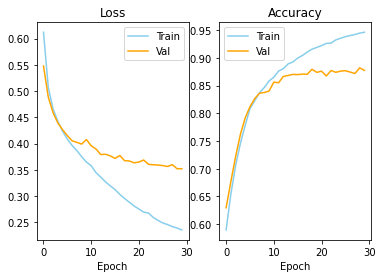

In [10]:
if mode == "train":
    model, train_loss, train_acc, valid_loss, valid_acc = train_model(model, device, n_epochs, batch_size, learning_rate, len(train_ds), len(valid_ds), dataloader)
    torch.save(model.state_dict(), os.path.join(save_dir, "seg_model_%s.pth" % model_type))
else:
    model.load_state_dict(torch.load(os.path.join(save_dir, "seg_model_%s.pth" % model_type)))

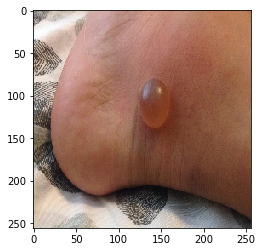

In [26]:
example_id = 11
show(valid_ds[example_id][0])

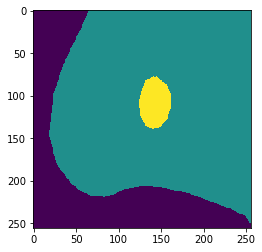

In [27]:
show(to_colorrep(valid_ds[example_id][1]))

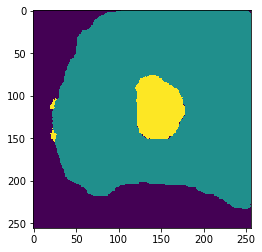

In [28]:
model.cpu()
pred = model(valid_ds[example_id][0].unsqueeze(0))[0].round()
show(to_colorrep(pred))